In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
import json
import os
import gensim.downloader as gensim_downloader
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import sys
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import subprocess


/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

df = load_dataset("ayjays132/Emotionverse")

## Data Cleaning

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Text cleaning functions
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove @mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def to_lowercase(text):
    return text.lower()

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Combined preprocessing function for Pandas DataFrame
def preprocess_text_pipeline(text):
    """Apply all preprocessing steps in sequence"""
    text = clean_text(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text



In [7]:
# Convert datasets object to pandas DataFrame first
import pandas as pd
df = pd.DataFrame(df['train'])

# Apply preprocessing to the text column
df['clean_text'] = df['text'].apply(preprocess_text_pipeline)

## EDA

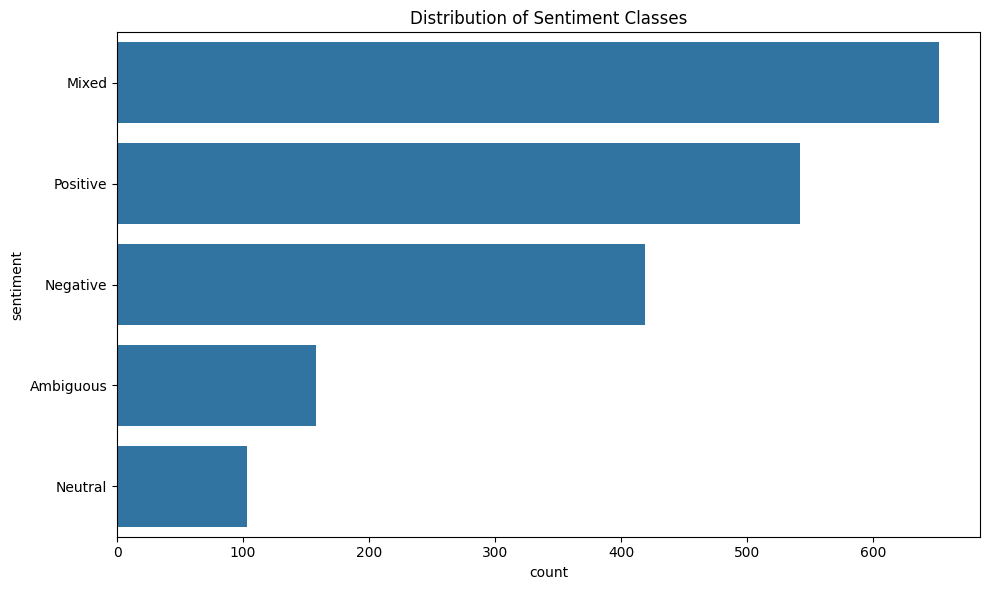

In [8]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.tight_layout()
plt.show()

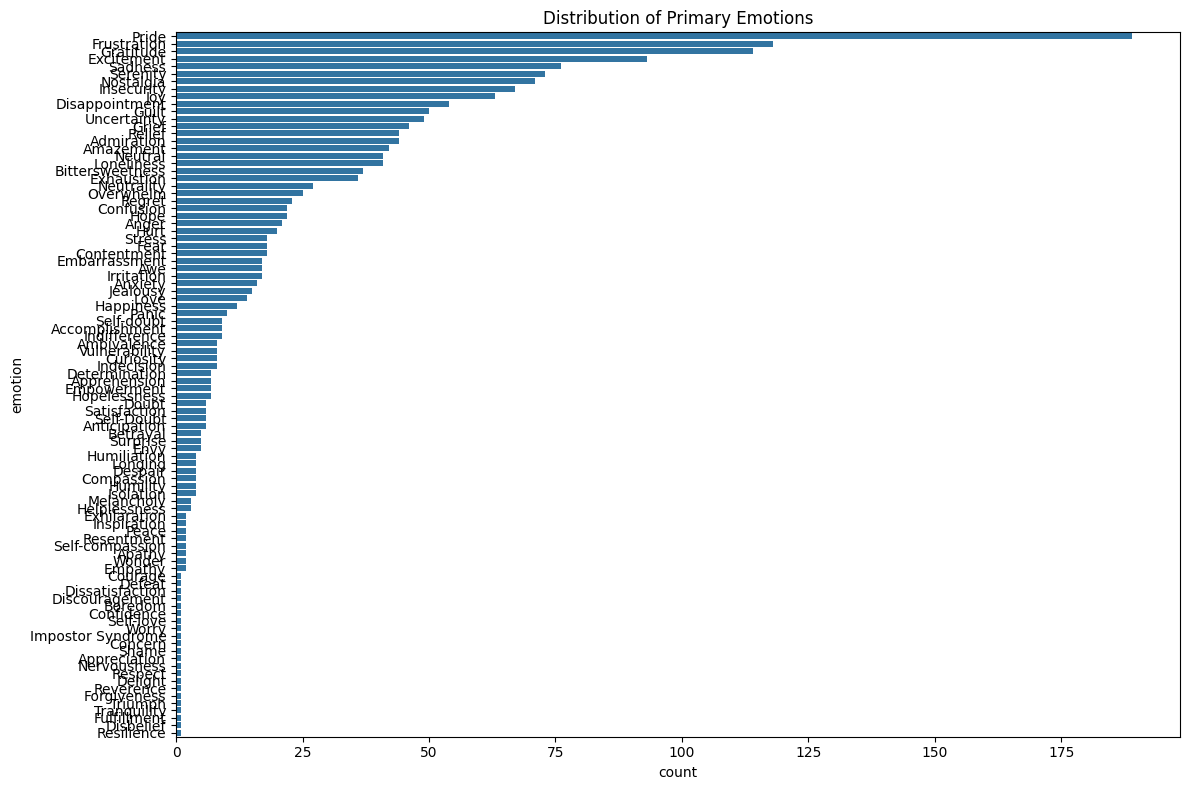

In [9]:
# Visualize primary emotions
plt.figure(figsize=(12, 8))
emotion_counts = Counter(df['primary_emotion'])
emotion_df = pd.DataFrame({'emotion': list(emotion_counts.keys()), 
                           'count': list(emotion_counts.values())})
emotion_df = emotion_df.sort_values('count', ascending=False)
sns.barplot(x='count', y='emotion', data=emotion_df)
plt.title('Distribution of Primary Emotions')
plt.tight_layout()
plt.show()

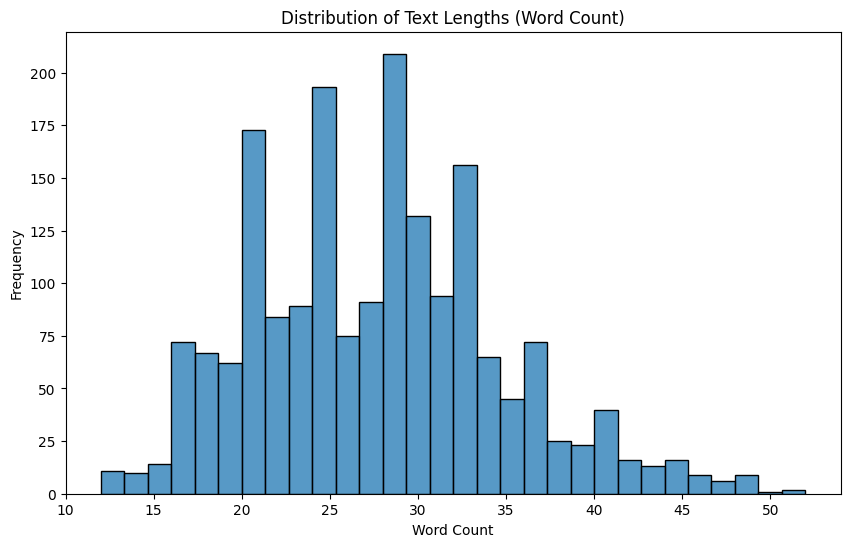

In [10]:
# Text length distribution
plt.figure(figsize=(10, 6))
text_lengths = [len(text.split()) for text in df['text']]
sns.histplot(text_lengths, bins=30)
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


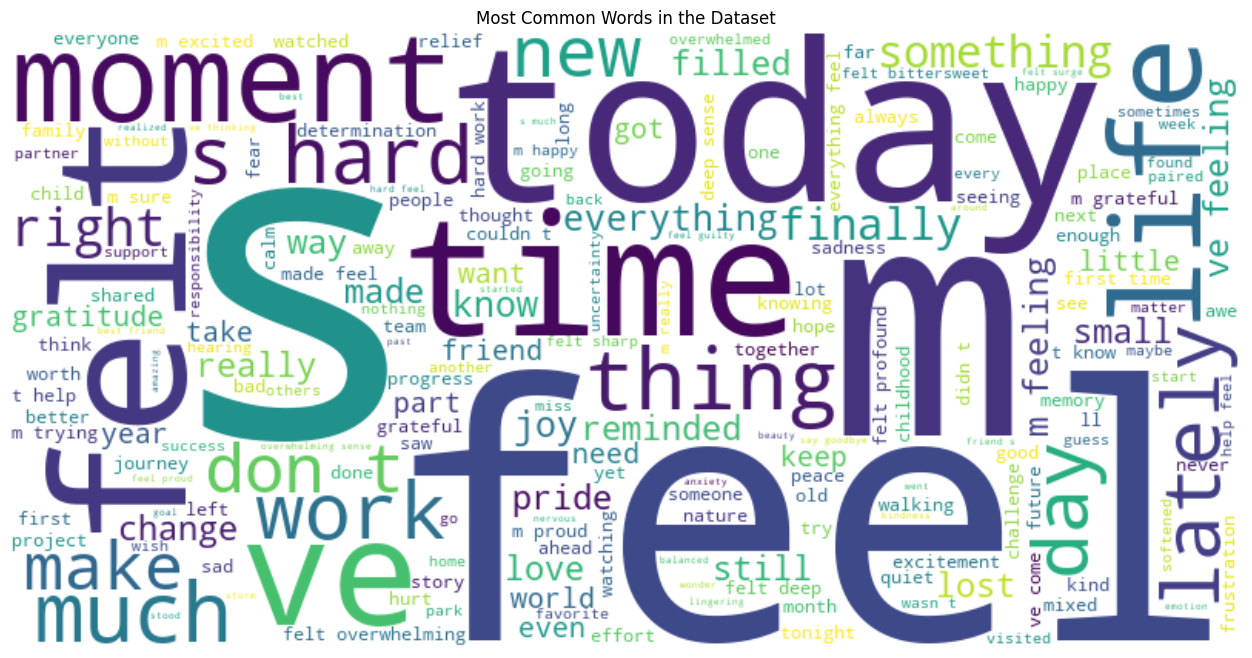

In [11]:
# Word cloud for visualizing common terms
all_text = ' '.join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()


## Feature Extraction
We will use different feature extraction techniques, so we can experiment afterwards and decide which ones work better.

In [12]:
# 1. Bag of Words (BoW) 
def extract_and_save_bow(df, max_features=5000, ngram_range=(1, 1), output_file='bow_features.npz'):
    print("Extracting Bag of Words features...")
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['clean_text'])
    
    # Save the sparse matrix
    sp.save_npz(output_file, X_bow)
    
    # Save feature names and vocabulary for later reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_bow.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)
    
    print(f"BoW Dimensions: {X_bow.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    
    return X_bow, vectorizer


In [13]:
# 2. TF-IDF 
def extract_and_save_tfidf(df, max_features=5000, ngram_range=(1, 1), output_file='tfidf_features.npz'):
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df['clean_text'])
    
    # Save the sparse matrix
    sp.save_npz(output_file, X_tfidf)
    
    # Save feature names and vocabulary for later reference
    feature_names = vectorizer.get_feature_names_out()
    vocab = vectorizer.vocabulary_
    
    with open(output_file.replace('.npz', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': feature_names.tolist(),
            'vocab_size': len(feature_names),
            'shape': X_tfidf.shape,
            'ngram_range': ngram_range,
            'max_features': max_features
        }, f)
    
    print(f"TF-IDF Dimensions: {X_tfidf.shape}")
    print(f"Feature space size: {len(feature_names)}")
    print(f"Saved to {output_file} and {output_file.replace('.npz', '_metadata.json')}")
    
    return X_tfidf, vectorizer

In [14]:
# 3. Word Embeddings with mean pooling
def extract_and_save_embeddings(df, embedding_model='glove-wiki-gigaword-300', output_file='embedding_features2.npy'):
    """
    Extract features using pre-trained word embeddings.
    Uses the mean of word vectors for each document.
    """
    print(f"Extracting Word Embedding features using {embedding_model}...")
    
    # Load pre-trained word vectors
    try:
        word_vectors = gensim_downloader.load(embedding_model)
        embedding_dim = word_vectors.vector_size
        print(f"Loaded {embedding_model} with dimension {embedding_dim}")
    except Exception as e:
        print(f"Error loading {embedding_model}: {e}")
        print("Available models:")
        print(gensim_downloader.info()['models'].keys())
        return None, None

    # Ensure nltk tokenizer is available
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading NLTK tokenizer...")
        nltk.download('punkt')
    
    # Create document vectors by averaging word vectors
    X_embeddings = np.zeros((len(df), embedding_dim))
    missing_words = set()
    
    for i, text in tqdm(enumerate(df['clean_text']), total=len(df), desc="Creating document vectors"):
        tokens = word_tokenize(text)
        if not tokens:
            continue
            
        vectors = []
        for token in tokens:
            if token in word_vectors:
                vectors.append(word_vectors[token])
            else:
                missing_words.add(token)
                
        if vectors:
            # Average the vectors
            X_embeddings[i] = np.mean(vectors, axis=0)
    
    # Notify about missing words
    missing_word_count = len(missing_words)
    print(f"Words not found in embedding vocabulary: {missing_word_count}")
    if missing_word_count > 0:
        print(f"Sample of missing words: {list(missing_words)[:10]}")
    
    # Save as numpy array since it's dense
    np.save(output_file, X_embeddings)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'embedding_model': embedding_model,
            'embedding_dim': embedding_dim,
            'shape': X_embeddings.shape,
            'missing_word_count': missing_word_count
        }, f)
    
    print(f"Word Embedding Dimensions: {X_embeddings.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    return X_embeddings, word_vectors


In [15]:
# 4. TF-IDF weighted embeddings - Combines TF-IDF with word embeddings
def extract_and_save_tfidf_embeddings(df, embedding_model='glove-wiki-gigaword-300', max_features=5000, output_file='tfidf_embedding_features2.npy'):
    """
    Extract features using TF-IDF weighted word embeddings.
    Each word's embedding is weighted by its TF-IDF score.
    """
    print(f"Extracting TF-IDF weighted Word Embedding features using {embedding_model}...")
    
    # Load pre-trained word vectors
    try:
        word_vectors = gensim_downloader.load(embedding_model)
        embedding_dim = word_vectors.vector_size
        print(f"Loaded {embedding_model} with dimension {embedding_dim}")
    except Exception as e:
        print(f"Error loading {embedding_model}: {e}")
        print("Available models:")
        print(gensim_downloader.info()['models'].keys())
        return None, None, None

    # Calculate TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create mapping from words to their index in TF-IDF vocabulary
    word_to_index = {word: idx for idx, word in enumerate(feature_names)}
    
    # Create document vectors by TF-IDF weighted averaging
    X_tfidf_embeddings = np.zeros((len(df), embedding_dim))
    missing_words = set()
    
    for i, text in tqdm(enumerate(df['clean_text']), total=len(df), desc="Creating TF-IDF weighted vectors"):
        words = text.split()
        if not words:
            continue
            
        # Get TF-IDF values for this document
        doc_tfidf = X_tfidf[i].toarray().flatten()
        
        # Calculate weighted sum of word vectors
        doc_vector = np.zeros(embedding_dim)
        weight_sum = 0
        
        for word in words:
            if word in word_to_index and word in word_vectors:
                idx = word_to_index[word]
                weight = doc_tfidf[idx]
                doc_vector += weight * word_vectors[word]
                weight_sum += weight
            elif word not in word_vectors:
                missing_words.add(word)
                
        # Normalize by sum of weights
        if weight_sum > 0:
            X_tfidf_embeddings[i] = doc_vector / weight_sum
    
    # Notify about missing words
    missing_word_count = len(missing_words)
    print(f"Words not found in embedding vocabulary: {missing_word_count}")
    if missing_word_count > 0:
        print(f"Sample of missing words: {list(missing_words)[:10]}")
    
    # Save as numpy array
    np.save(output_file, X_tfidf_embeddings)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'embedding_model': embedding_model,
            'embedding_dim': embedding_dim,
            'tfidf_max_features': max_features,
            'shape': X_tfidf_embeddings.shape,
            'missing_word_count': missing_word_count
        }, f)
    
    print(f"TF-IDF Weighted Embedding Dimensions: {X_tfidf_embeddings.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    return X_tfidf_embeddings, word_vectors, tfidf_vectorizer

In [16]:
# 5. Sentiment Lexicon

def extract_and_save_lexicon_features(df, output_file='lexicon_features.npy'):
    print("Extracting Sentiment Lexicon features...")
    
    # Download VADER lexicon if not already downloaded
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')
    
    # Initialize VADER sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    
    # Create features array - 4 features per document
    # (negative, neutral, positive, compound scores)
    X_lexicon = np.zeros((len(df), 4))
    
    for i, text in tqdm(enumerate(df['text']), total=len(df), desc="Creating lexicon features"):
        # Get sentiment scores
        sentiment_scores = sid.polarity_scores(text)
        
        # Store scores in feature array
        X_lexicon[i, 0] = sentiment_scores['neg']
        X_lexicon[i, 1] = sentiment_scores['neu']
        X_lexicon[i, 2] = sentiment_scores['pos']
        X_lexicon[i, 3] = sentiment_scores['compound']
    
    # Save as numpy array
    np.save(output_file, X_lexicon)
    
    # Save metadata
    with open(output_file.replace('.npy', '_metadata.json'), 'w') as f:
        json.dump({
            'feature_names': ['negative', 'neutral', 'positive', 'compound'],
            'shape': X_lexicon.shape,
            'lexicon': 'VADER'
        }, f)
    
    print(f"Lexicon Features Dimensions: {X_lexicon.shape}")
    print(f"Saved to {output_file} and {output_file.replace('.npy', '_metadata.json')}")
    
    return X_lexicon

In [17]:
# 6. Save the original dataset with IDs for later joining
def save_labels_and_ids(df, output_file='emotionverse_labels.csv'):
    # Create a subset of the dataframe with just the necessary columns
    labels_df = df[['sentiment', 'primary_emotion']].copy()
    labels_df['id'] = list(range(len(df)))  # Add ID column
    
    # Save to CSV
    labels_df.to_csv(output_file, index=False)
    print(f"Labels saved to {output_file}")
    
    return labels_df

In [18]:
# Main execution
def extract_all_features(df, output_dir='features', embedding_model='glove-wiki-gigaword-300'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Set file paths
    bow_file = os.path.join(output_dir, 'bow_features.npz')
    tfidf_file = os.path.join(output_dir, 'tfidf_features.npz')
    embedding_file = os.path.join(output_dir, 'embedding_features.npy')
    tfidf_embedding_file = os.path.join(output_dir, 'tfidf_embedding_features.npy')
    labels_file = os.path.join(output_dir, 'emotionverse_labels.csv')
    
    # Extract and save all features
    X_bow, bow_vectorizer = extract_and_save_bow(df, output_file=bow_file)
    X_tfidf, tfidf_vectorizer = extract_and_save_tfidf(df, output_file=tfidf_file)
    X_embeddings, word_vectors = extract_and_save_embeddings(df, embedding_model=embedding_model, output_file=embedding_file)
    X_tfidf_embeddings, _, tfidf_emb_vectorizer = extract_and_save_tfidf_embeddings(df, embedding_model=embedding_model, output_file=tfidf_embedding_file)
    labels_df = save_labels_and_ids(df, output_file=labels_file)

    # Add lexicon features
    lexicon_file = os.path.join(output_dir, 'lexicon_features.npy')
    X_lexicon = extract_and_save_lexicon_features(df, output_file=lexicon_file)
    
    print("\nFeature extraction complete!")
    print(f"All features saved to {output_dir}/")
    
    return {
        'bow': (X_bow, bow_vectorizer),
        'tfidf': (X_tfidf, tfidf_vectorizer),
        'embeddings': (X_embeddings, word_vectors),
        'tfidf_embeddings': (X_tfidf_embeddings, word_vectors, tfidf_emb_vectorizer),
        'lexicon': X_lexicon,  
        'labels': labels_df
    }

In [19]:
def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import gensim
except ImportError:
    install_package("gensim")
    import gensim

In [20]:
# Create features directory
output_dir = 'emotionverse_features'
os.makedirs(output_dir, exist_ok=True)

In [21]:
# Choose an embedding model - smaller for faster processing
# Options:
# - 'glove-twitter-25' (faster, Twitter data, 25-dim)
# - 'glove-wiki-gigaword-100' (medium, Wikipedia data, 100-dim)
# - 'word2vec-google-news-300' (slower, Google News data, 300-dim)
embedding_model = 'glove-wiki-gigaword-100'  # Middle option for testing

In [22]:
# Execute feature extraction and save results
features = extract_all_features(df, output_dir=output_dir, embedding_model=embedding_model)


Extracting Bag of Words features...
BoW Dimensions: (1874, 3081)
Feature space size: 3081
Saved to emotionverse_features/bow_features.npz and emotionverse_features/bow_features_metadata.json
Extracting TF-IDF features...
TF-IDF Dimensions: (1874, 3081)
Feature space size: 3081
Saved to emotionverse_features/tfidf_features.npz and emotionverse_features/tfidf_features_metadata.json
Extracting Word Embedding features using glove-wiki-gigaword-100...
[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded glove-wiki-gigaword-100 with dimension 100


Creating document vectors: 100%|██████████| 1874/1874 [00:00<00:00, 13363.67it/s]

Words not found in embedding vocabulary: 317
Sample of missing words: ['🤷', '😎', '🏀', 'stillness—neither', '🌱', '🌀', '🍹', 'emotions—some', '😬', '🥀']
Word Embedding Dimensions: (1874, 100)
Saved to emotionverse_features/embedding_features.npy and emotionverse_features/embedding_features_metadata.json
Extracting TF-IDF weighted Word Embedding features using glove-wiki-gigaword-100...


Loaded glove-wiki-gigaword-100 with dimension 100


Creating TF-IDF weighted vectors: 100%|██████████| 1874/1874 [00:00<00:00, 15065.50it/s]


Words not found in embedding vocabulary: 415
Sample of missing words: ['🤷', '😎', '🏀', 'stillness—neither', '🌱', '🌀', '🍹', 'emotions—some', '😬', '🥀']
TF-IDF Weighted Embedding Dimensions: (1874, 100)
Saved to emotionverse_features/tfidf_embedding_features.npy and emotionverse_features/tfidf_embedding_features_metadata.json
Labels saved to emotionverse_features/emotionverse_labels.csv
Extracting Sentiment Lexicon features...


Creating lexicon features: 100%|██████████| 1874/1874 [00:00<00:00, 6295.71it/s]


Lexicon Features Dimensions: (1874, 4)
Saved to emotionverse_features/lexicon_features.npy and emotionverse_features/lexicon_features_metadata.json

Feature extraction complete!
All features saved to emotionverse_features/
